In [26]:
import matplotlib.pyplot as plt
import math
import json
import re

from utils import num_of_batch_sizes

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def extract_label_value(label, key):
    return int(label.split(key)[1].split(".txt")[0].split("_")[1])

def get_model_info(label, key):
    model_name = extract_model_name(label)
    info = {
        "qwen-0.5b": {
            "layers": 24,
            "attn_heads": 16,
            "attn_heads_num": 16,
            "hidden_size": 1024,
            "vocab_size": 151936,
            "tokenizer_size": 6800
        },
        "qwen-1.8b": {
            "layers": 24,
            "attn_heads": 16,
            "attn_heads_num": 16,
            "hidden_size": 2048,
            "vocab_size": 151936,
            "tokenizer_size": 6800
        },
        "qwen-4b": {
            "layers": 40,
            "attn_heads": 20,
            "attn_heads_num": 20,
            "hidden_size": 2560,
            "vocab_size": 151936,
            "tokenizer_size": 6800
        },
        "qwen-7b": {
            "layers": 32,
            "attn_heads": 32,
            "attn_heads_num": 32,
            "hidden_size": 4096,
            "vocab_size": 151936,
            "tokenizer_size": 6800
        },
        "qwen-14b": {
            "layers": 40,
            "attn_heads": 40,
            "attn_heads_num": 40,
            "hidden_size": 5120,
            "vocab_size": 152064,
            "tokenizer_size": 6800
        },
        "llama2-7b-hf": {
            "layers": 32,
            "attn_heads": 32,
            "attn_heads_num": 32,
            "hidden_size": 4096,
            "vocab_size": 32000,
            "tokenizer_size": 1800
        },
        "llama2-13b-hf": {
            "layers": 40,
            "attn_heads": 40,
            "attn_heads_num": 40,
            "hidden_size": 5120,
            "vocab_size": 32000,
            "tokenizer_size": 1800
        },
        "llama3-3b": {
            "layers": 28,
            "attn_heads": 8,
            "attn_heads_num": 24,
            "hidden_size": 3072,
            "vocab_size": 128256,
            "tokenizer_size": 8700
        },
        "falcon-7b": {
            "layers": 32,
            "attn_heads": 1,
            "attn_heads_num": 71,
            "hidden_size": 4544,
            "vocab_size": 65024,
            "tokenizer_size": 2700
        },
        "yi-6b": {
            "layers": 32,
            "attn_heads": 4,
            "attn_heads_num": 32,
            "hidden_size": 4096,
            "vocab_size": 64000,
            "tokenizer_size": 3500
        },
        "yi-9b": {
            "layers": 48,
            "attn_heads": 4,
            "attn_heads_num": 32,
            "hidden_size": 4096,
            "vocab_size": 64000,
            "tokenizer_size": 3500
        },
        "opt-1.3b": {
            "layers": 24,
            "attn_heads": 32,
            "attn_heads_num": 32,
            "hidden_size": 2048,
            "vocab_size": 50272,
            "tokenizer_size": 1300
        },
        "opt-2.7b": {
            "layers": 32,
            "attn_heads": 32,
            "attn_heads_num": 32,
            "hidden_size": 2560,
            "vocab_size": 50272,
            "tokenizer_size": 1300
        },
        "opt-6.7b": {
            "layers": 32,
            "attn_heads": 32,
            "attn_heads_num": 32,
            "hidden_size": 4096,
            "vocab_size": 50272,
            "tokenizer_size": 1300
        },
        "opt-13b": {
            "layers": 40,
            "attn_heads": 40,
            "attn_heads_num": 40,
            "hidden_size": 5120,
            "vocab_size": 50272,
            "tokenizer_size": 1300
        },
    }
    
    return info[model_name].get(key, 0)


def extract_nb_layers(label):
    return get_model_info(label, "layers")

def extract_vocab_size(label):
    return get_model_info(label, "vocab_size")

def extract_tokenizer_size(label):
    return get_model_info(label, "tokenizer_size")

def extract_head_size_x_layers(label):
    attn_heads = get_model_info(label, "attn_heads")
    attn_heads_num = get_model_info(label, "attn_heads_num")
    hidden_size = get_model_info(label, "hidden_size")
    num_layers = get_model_info(label, "layers")
    return num_layers * hidden_size * (attn_heads / attn_heads_num) - 1

def extract_model_name(label):
    return label.split("model_")[1].split("_")[0].split(".txt")[0]

def extract_cuda_graph_size(label):
    return extract_label_value(label, "cuda-graph-sizes")

def extract_max_seq_len_to_capture(label):
    return extract_label_value(label, "max-seq-len-to-capture")

def extract_batch_size(label):
    return num_of_batch_sizes(extract_cuda_graph_size(label))

def extract_model_size(label):
    model_name = extract_model_name(label)
    size = model_name.split("-")[1]
    num = float(size[:-1])
    if "m" in size:
        num /= 1000
    
    return num

def get_sort_indices(labels, sort_by="model_size"):

    if sort_by == "model_size":
        sizes = [extract_model_size(label) for label in labels]
        return sorted(range(len(labels)), key=lambda i: sizes[i])
    elif sort_by == "alphabetical":
        return sorted(range(len(labels)), key=lambda i: natural_sort_key(labels[i]))
    
def get_labels_matrics(json_filepath, sort_by):
    with open(json_filepath, 'r') as f:
        json_data = json.load(f)

    labels = json_data['labels']
    metrics = json_data['data']
    
    # Modify metrics
    
    # Substract torch.compile, graph_compile_cached from kv_cache_profiling
    metrics['kv_cache_profiling'] = [
        metrics['kv_cache_profiling'][i] - metrics['torch.compile'][i] - (metrics['graph_compile_cached'][i] if metrics['graph_compile_cached'][i] is not None else 0)
        for i in range(len(metrics['kv_cache_profiling']))
    ]
    
    # No need for model_loading (it's just a sum of load_weights and model_init)
    del metrics['model_loading']
    
    # No need for torch.compile (it's just a sum of dynamo_transfer_time and graph_compile_general_shape)
    del metrics['torch.compile']
    
    # No need for init_engine (it's just a sum of kv_cache_profiling and graph_capturing)
    del metrics['init_engine']
    
    # No need for kv_cache_init (it's just constant time for all models ~0.01s)
    if 'kv_cache_init' in metrics:
        del metrics['kv_cache_init']
    
    # No need for actual_total_time (it's just same as total_time + 14s platform detection overhead)
    del metrics['actual_total_time']
    
    sort_indices = get_sort_indices(labels, sort_by)
    sorted_labels = [labels[i] for i in sort_indices]
    
    return metrics, sorted_labels, sort_indices

def draw_graph(json_file_path, sort_by):
    
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_file_path, sort_by)

    # Number of metrics (keys in 'data')
    num_metrics = len(metrics)
    cols = 3  # number of columns in the subplot grid
    rows = math.ceil(num_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()
    
    # Custom naming for batch size
    for i, label in enumerate(sorted_labels):
        if "cuda-graph-sizes" in label:
            cuda_graph_sizes = extract_cuda_graph_size(label)
            num_batches = num_of_batch_sizes(cuda_graph_sizes)
            sorted_labels[i] = label.replace(f"cuda-graph-sizes_{cuda_graph_sizes}", f"batch-size_{num_batches}")

    for idx, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[idx]
        cleaned_values = [v if v is not None else 0 for v in values]
        sorted_values = [cleaned_values[i] for i in sort_indices]
        bars = ax.bar(range(len(sorted_labels)), sorted_values)
        ax.set_title(metric_name)
        ax.set_xticks(range(len(sorted_labels)))
        ax.set_xticklabels(
            [label.replace("output_", "").replace("model_", "").replace(".txt", "") for label in sorted_labels],
            rotation=90,
            fontsize=10
        )
        ax.set_ylabel("Time (s)")
        max_val = max(cleaned_values)
        upper = max_val * 1.15 if max_val > 0 else 1
        ax.set_ylim(0, upper)
        
        # Annotate each bar with its height
        for bar in bars:
            height = bar.get_height()
            if height == 0:
                continue
            offset = 0.05 * max(cleaned_values)  # 5% of max value
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + offset if height > 0 else offset,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    # Increase vertical spacing
    fig.tight_layout(h_pad=2.5)

    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

def draw_multiple_relationships(values_list, sorted_labels_list, titles, xlabel, y_axis_func):
    assert len(values_list) == len(sorted_labels_list) == len(titles), "All input lists must have the same length"

    num_plots = len(values_list)
    cols = 3
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, (values, sorted_labels, title) in enumerate(zip(values_list, sorted_labels_list, titles)):
        ax = axes[idx]

        # Data from the table
        models = [extract_model_name(sorted_labels[i]) for i in range(len(sorted_labels))]
        param_sizes = np.array([y_axis_func(sorted_labels[i]) for i in range(len(sorted_labels))]).reshape(-1, 1)
        times = np.array(values)

        # Linear regression
        reg = LinearRegression().fit(param_sizes, times)
        predicted_times = reg.predict(param_sizes)

        # Plotting
        ax.scatter(param_sizes, times, color='blue', label='Actual Data')
        ax.plot(param_sizes, predicted_times, color='red', linestyle='--', label='Linear Fit')
        for i, label in enumerate(models):
            ax.text(param_sizes[i], times[i] + 0.2, label, ha='center', fontsize=8)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Time (s)")
        ax.grid(True)
        ax.legend()

    # Hide any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def draw_relationship(json_filepath, order_by, keys, xlabel, y_axis_func):
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, order_by)

    values_list = []
    sorted_labels_list = []
    titles = []

    for k in keys:
        # y = []
        # x = []
        # for j in range(len(sorted_labels)):
        #     if "qwen" in sorted_labels[j]:
        #         x.append(metrics[k][sort_indices[j]])
        #         y.append(sorted_labels[j])
        # values_list.append(x)
        # sorted_labels_list.append(y)
            
        values_list.append([metrics[k][sort_indices[i]] for i in range(len(sorted_labels))])
        sorted_labels_list.append(sorted_labels)
        titles.append(f"{k} vs Model Size")

    draw_multiple_relationships(
        values_list=values_list,
        sorted_labels_list=sorted_labels_list,
        titles=titles,
        xlabel=xlabel,
        y_axis_func=y_axis_func
    )

## Model Size

### Graph Compilation Not Cached

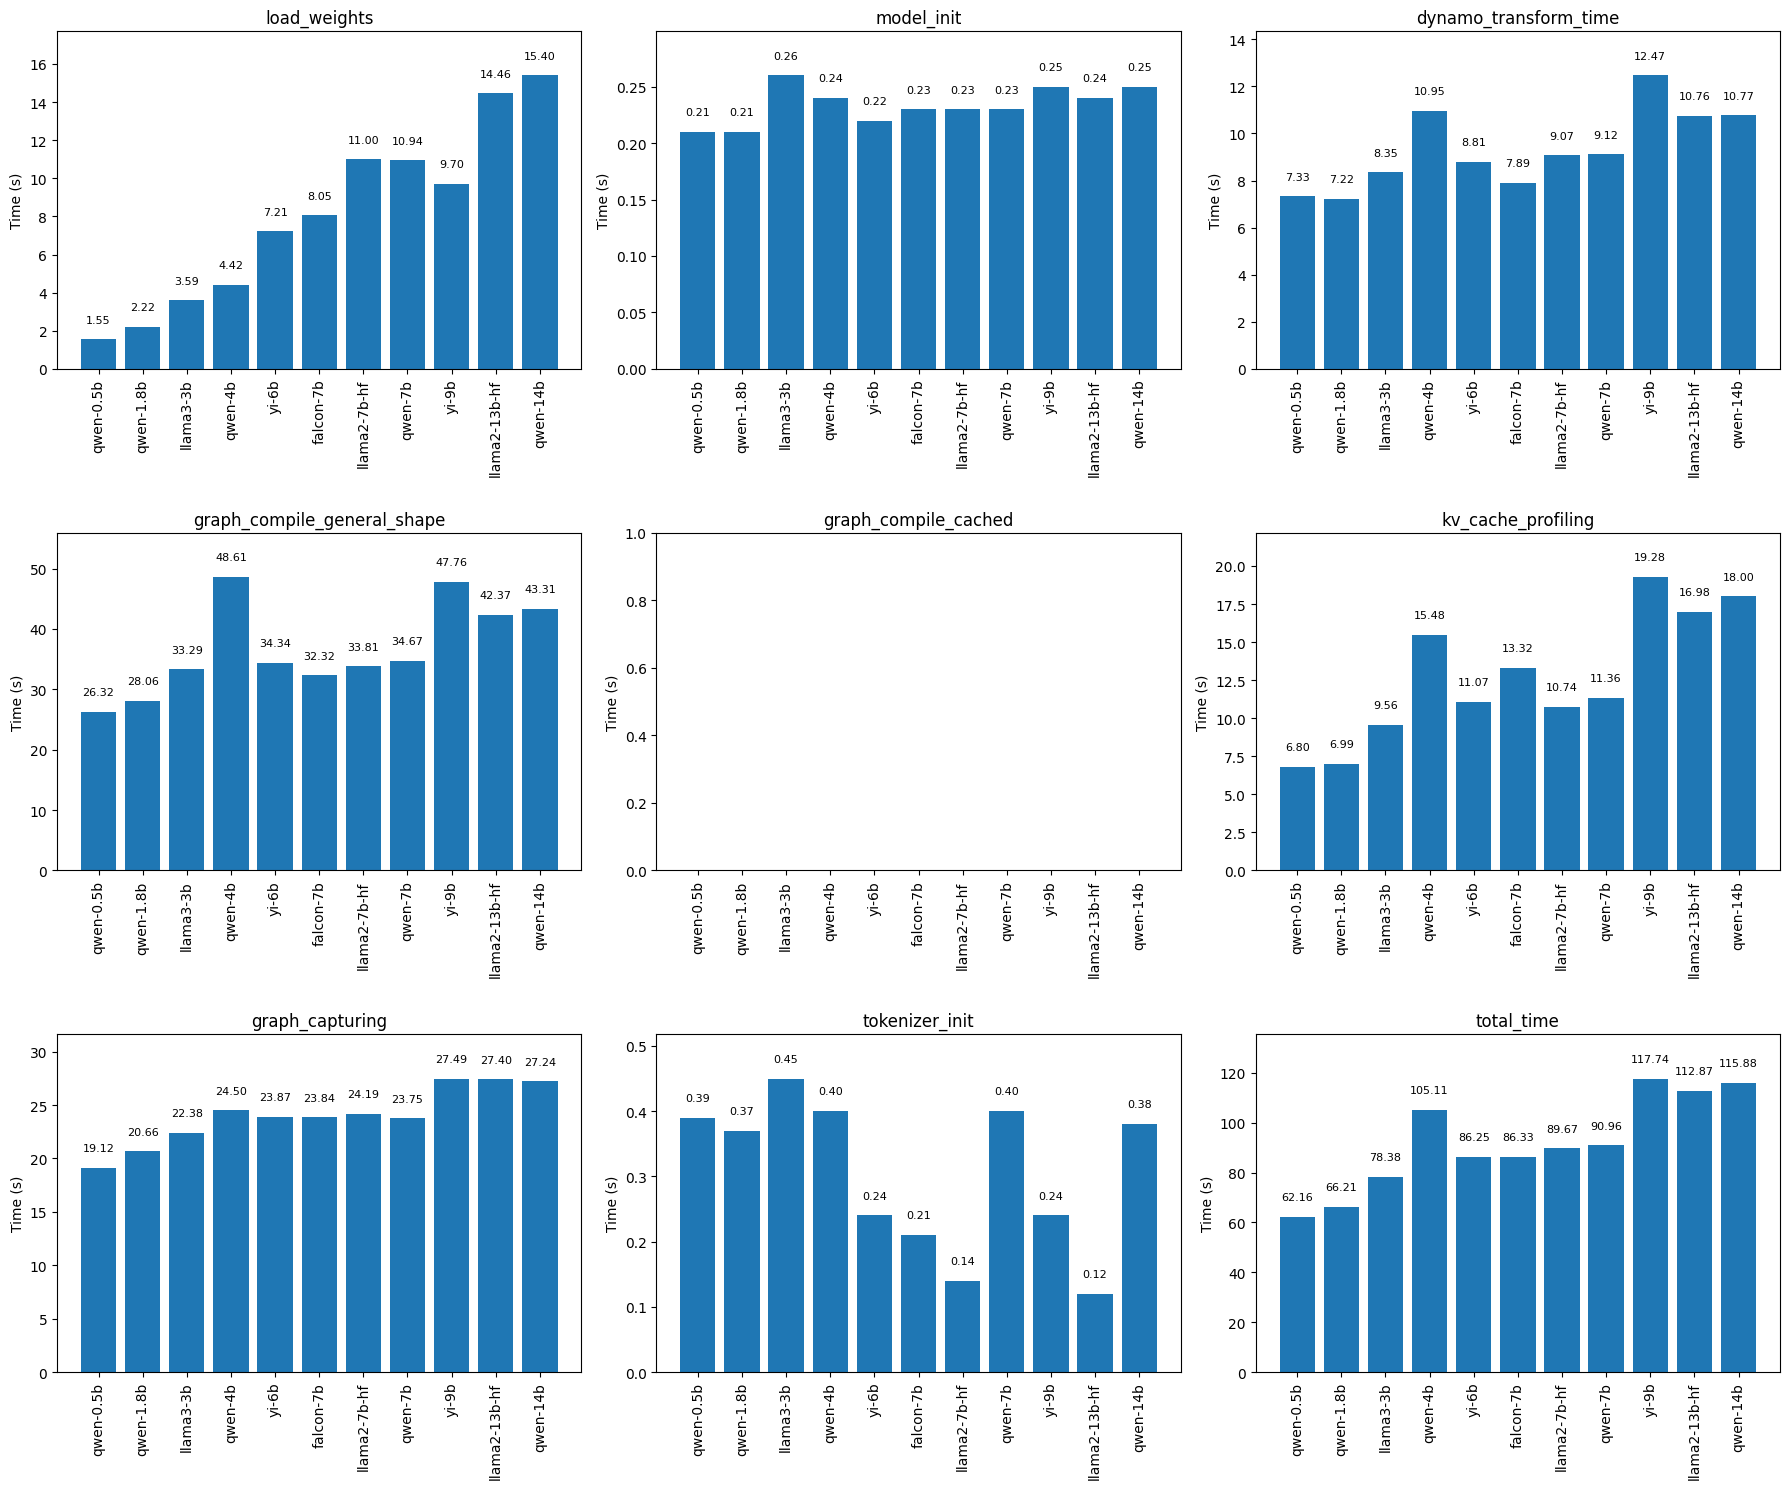

In [5]:
model_size_not_cached_json_filepath = "examples/model_size/not_cached/comparison_results.json"
draw_graph(model_size_not_cached_json_filepath, "model_size")

### Graph Compilation Cached

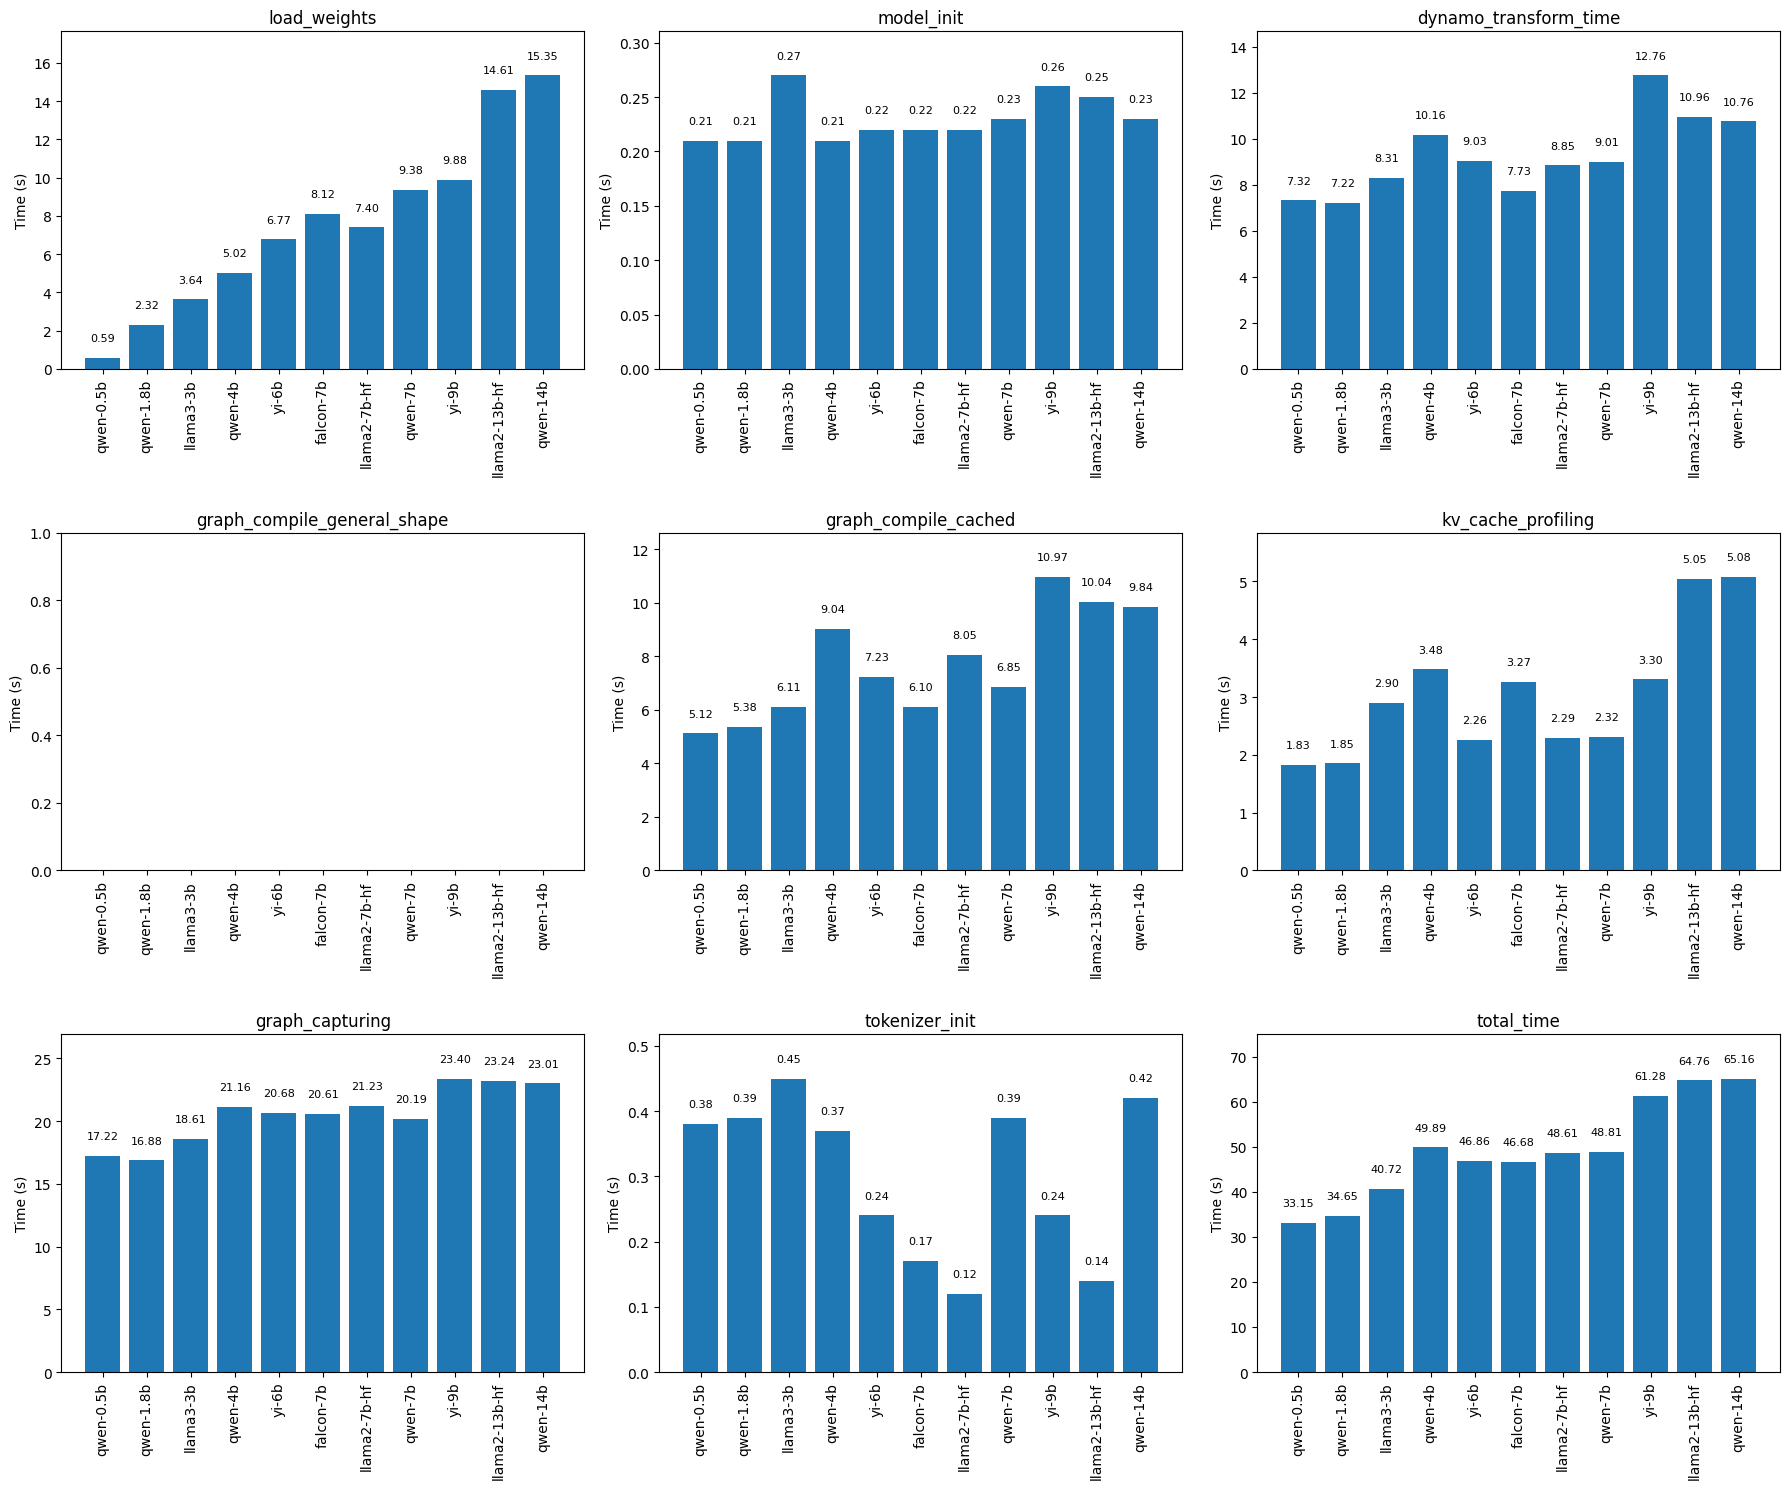

In [16]:
model_size_json_filepath = "examples/model_size/comparison_results.json"
draw_graph(model_size_json_filepath, "model_size")

### Analysis:

```text
Loading weights seems to follow linear relationship with model size

Model init is constant

dynamo_transform_time, graph_compile_cached and kv_cache_profiling seems to have constant + dynamic overhead
The relationship is not quite linear, there seems to be constant overhead even for very small models
Then there is some dynamic overhead depending on the size

For Graph Capturing the constant overhead seems to dominate
It doesn't seem to be affected a lot with model size.
It's mainly affected by the number of compiled batch sizes

Internstingly, tokenizer init time is mainly affected by the model architicture
For example, for all Qwen models, it takes ~0.39s
For llama2 models it's about ~0.13s
For Yi models, it's 0.24s
```

#### Relation Plots

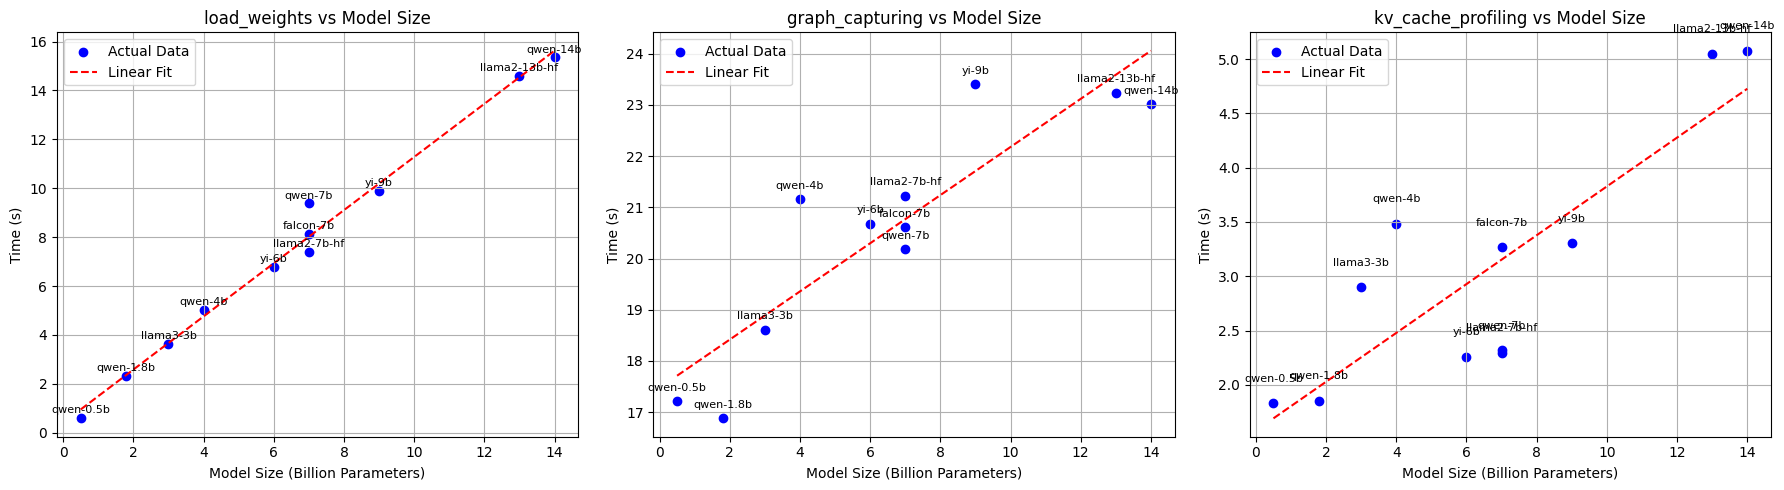

In [7]:
keys = ["load_weights", "graph_capturing", "kv_cache_profiling"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Model Size (Billion Parameters)", extract_model_size)

#### Relation between graph_compile_cached, dynamo_transform_time and nb_layers

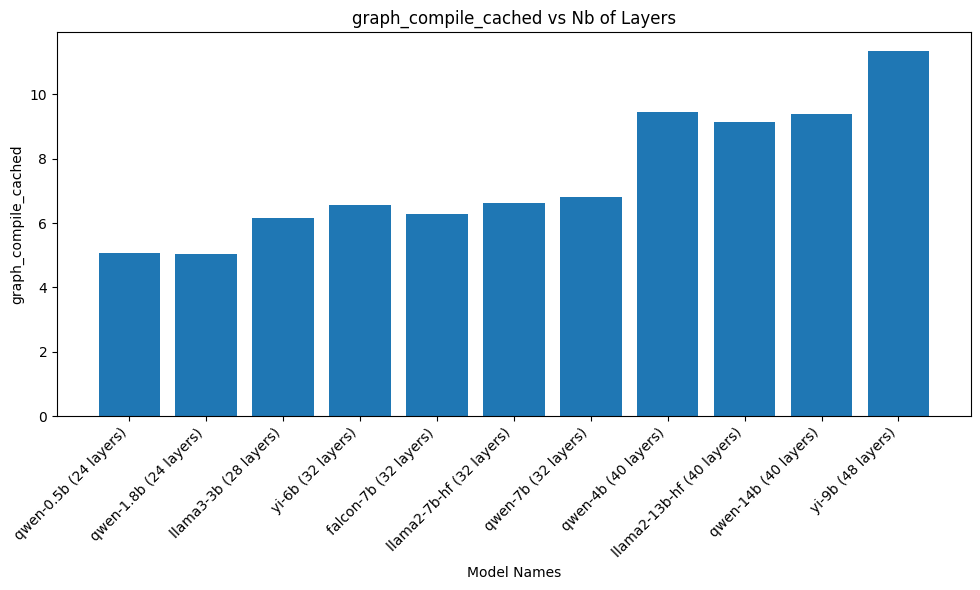

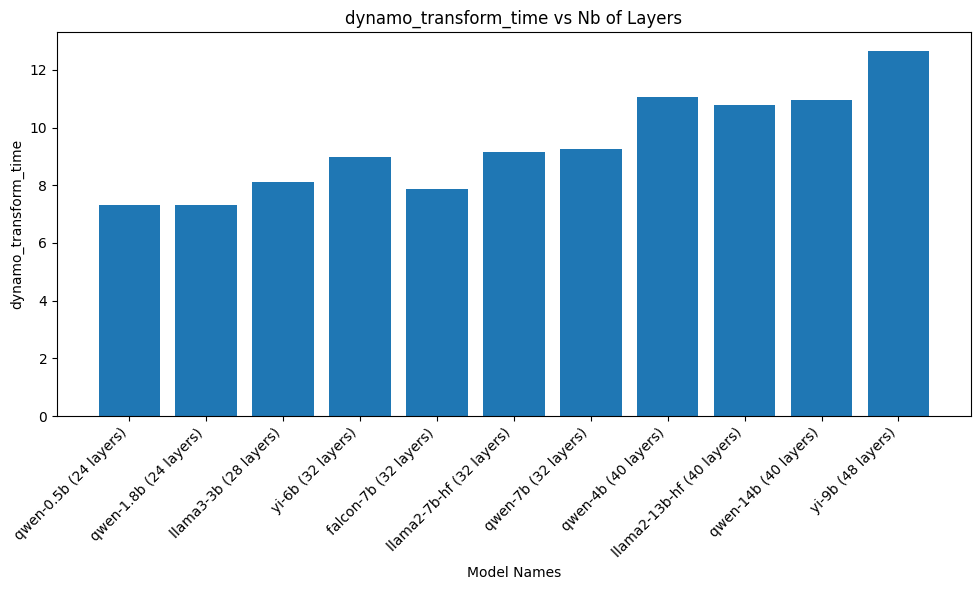

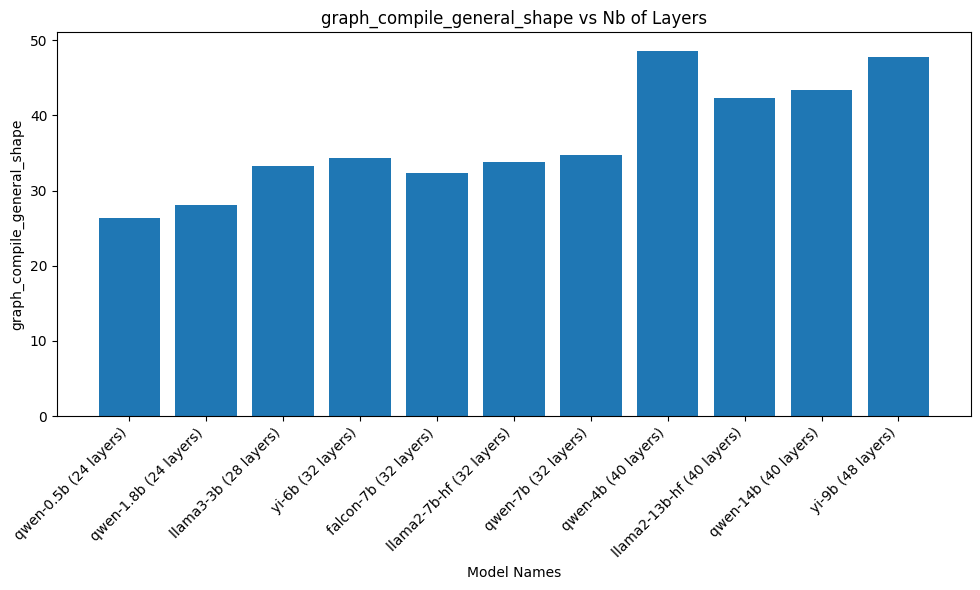

In [ ]:
def draw_metric_wrt_layers(json_filepath, metric):
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, "model_size")

    metric_values = [metrics[metric][sort_indices[i]] for i in range(len(sorted_labels))]
    model_names = [extract_model_name(label) for label in sorted_labels]
    model_layers_nb = [get_model_info(label, "layers") for label in sorted_labels]

    # Now sort the values and model names based on the number of layers
    sorted_indices = sorted(range(len(model_layers_nb)), key=lambda i: model_layers_nb[i])
    metric_values = [metric_values[i] for i in sorted_indices]
    model_names = [model_names[i] for i in sorted_indices]
    model_layers_nb = [model_layers_nb[i] for i in sorted_indices]

    labels = [f"{model_names[i]} ({model_layers_nb[i]} layers)" for i in range(len(model_names))]

    # Now draw a graph of graph_compile_cached vs model_layers_nb
    plt.figure(figsize=(10, 6))
    plt.bar(labels, metric_values)
    plt.xlabel("Model Names")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Nb of Layers")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
draw_metric_wrt_layers("examples/tmp/comparison_results.json", "graph_compile_cached")
draw_metric_wrt_layers("examples/tmp/comparison_results.json", "dynamo_transform_time")
draw_metric_wrt_layers("examples/model_size/not_cached/comparison_results.json", "graph_compile_general_shape")

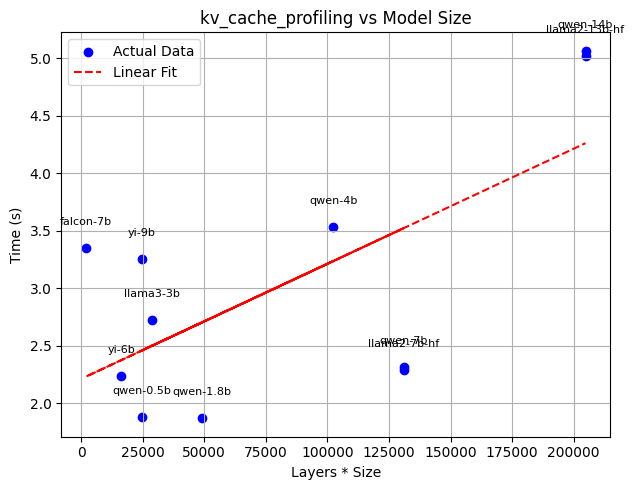

In [84]:
# keys = ["graph_compile_cached", "dynamo_transform_time"]
# draw_relationship("examples/tmp/comparison_results.json", "model_size", keys, "Number Of Layers", extract_nb_layers)

# keys = ["graph_compile_general_shape"]
# draw_relationship("examples/model_size/not_cached/comparison_results.json", "model_size", keys, "Number Of Layers", extract_nb_layers)

keys = ["kv_cache_profiling"]
draw_relationship("examples/tmp/comparison_results.json", "model_size", keys, "Layers * Size", extract_head_size_x_layers)

#### Observations:

```text
When 2 models have exactly same nb_layers and same nb_heads, they have same time
Examples: Qwen-0.5B and Qwen-1.8B | Qwen-7B and Llama2-7B | Qwen-14B and Llama2-13B
```

#### Relation between tokenizer_init_time and vocab_size

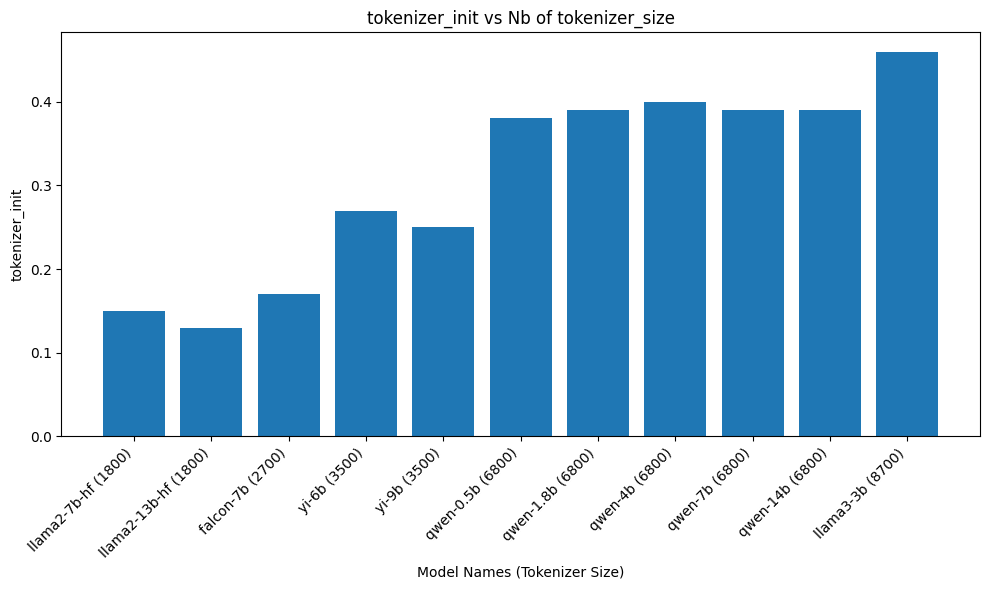

In [33]:
def draw_metric_wrt_tokenizer_size(json_filepath, metric):
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, "model_size")

    metric_values = [metrics[metric][sort_indices[i]] for i in range(len(sorted_labels))]
    model_names = [extract_model_name(label) for label in sorted_labels]
    model_tokenizer_size = [get_model_info(label, "tokenizer_size") for label in sorted_labels]

    # Now sort the values and model names based on the number of tokenizer_size
    sorted_indices = sorted(range(len(model_tokenizer_size)), key=lambda i: model_tokenizer_size[i])
    metric_values = [metric_values[i] for i in sorted_indices]
    model_names = [model_names[i] for i in sorted_indices]
    model_tokenizer_size = [model_tokenizer_size[i] for i in sorted_indices]

    labels = [f"{model_names[i]} ({model_tokenizer_size[i]})" for i in range(len(model_names))]

    # Now draw a graph of graph_compile_cached vs model_tokenizer_size
    plt.figure(figsize=(10, 6))
    plt.bar(labels, metric_values)
    plt.xlabel("Model Names (Tokenizer Size)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Nb of tokenizer_size")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
draw_metric_wrt_tokenizer_size("examples/tmp/comparison_results.json", "tokenizer_init")

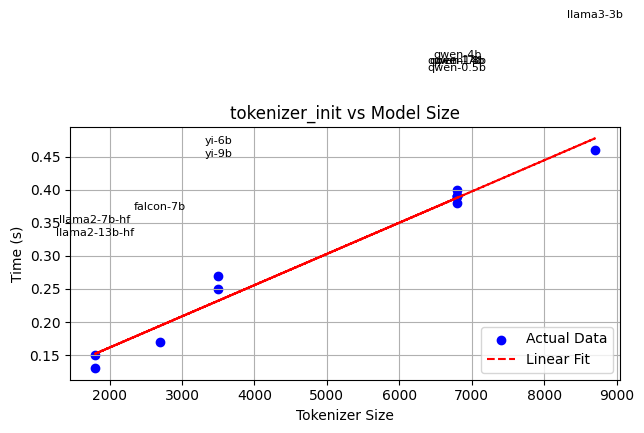

In [32]:
draw_relationship("examples/tmp/comparison_results.json", "model_size", ["tokenizer_init"], "Tokenizer Size", extract_tokenizer_size)

## Batch Size

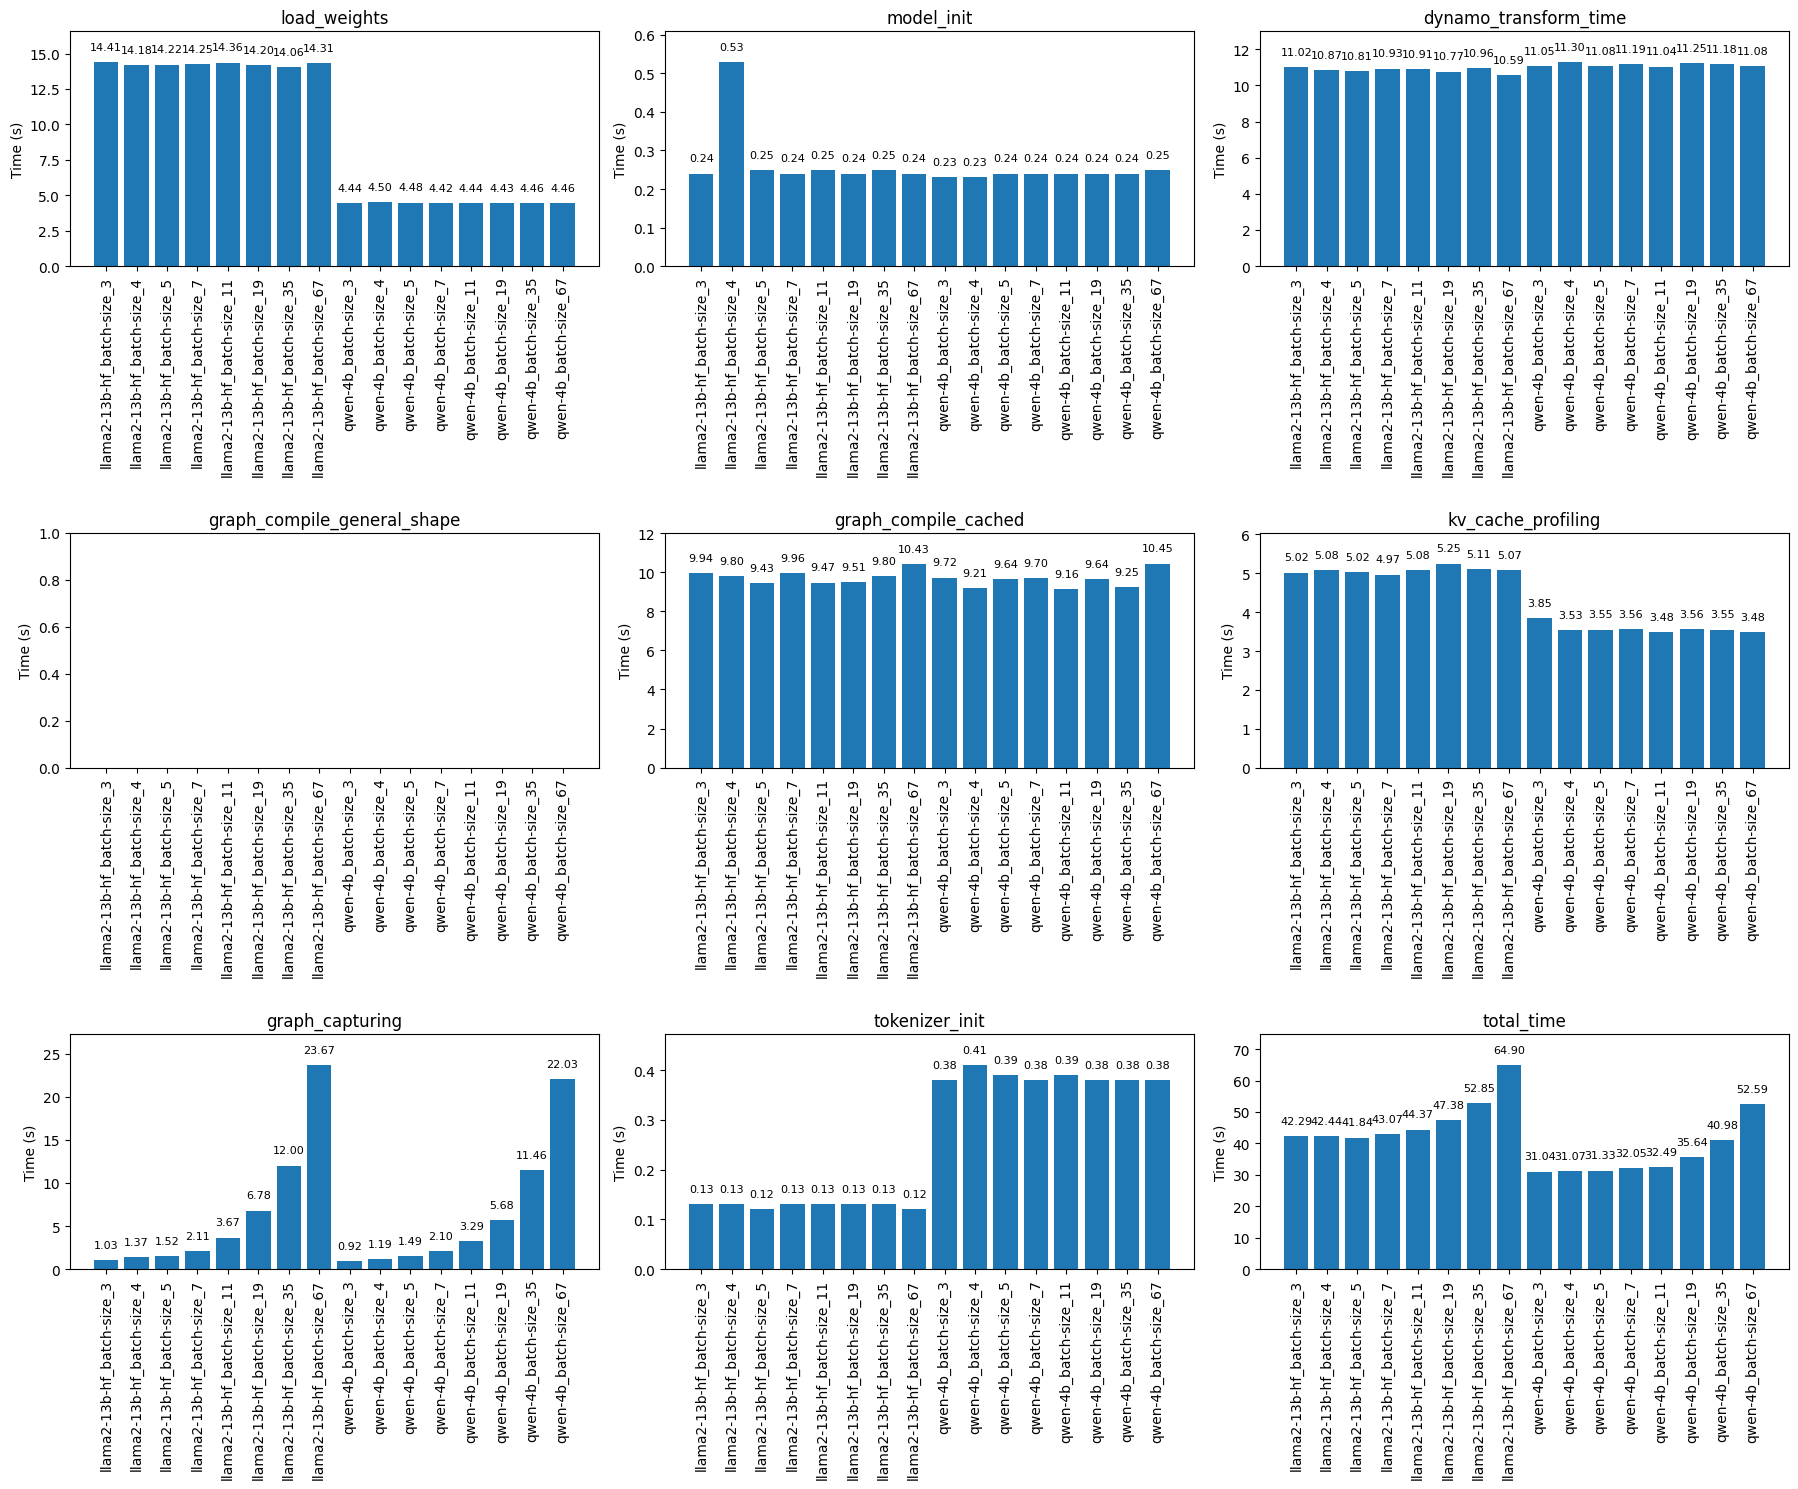

In [10]:
batch_size_json_filepath = "examples/batch_size/comparison_results.json"
draw_graph(batch_size_json_filepath, "alphabetical")

### Analysis

Changing the number of compiled batch sizes affects only the time spent for CUDA graph capture (as expected)

The relationship seems to be linear

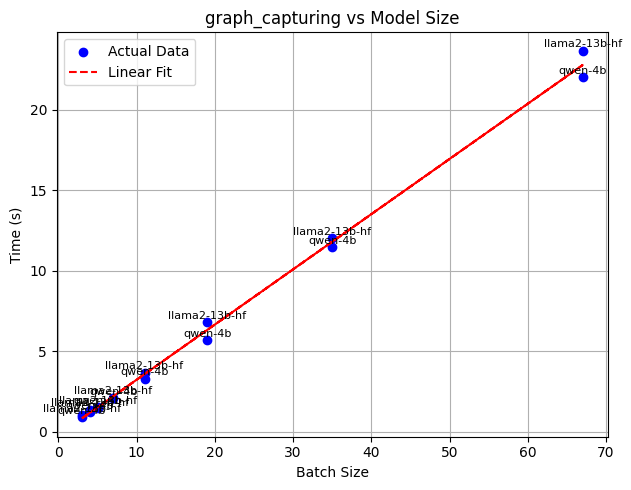

In [11]:
draw_relationship(batch_size_json_filepath, "alphabetical", ["graph_capturing"], "Batch Size", extract_batch_size)

## GPU Util

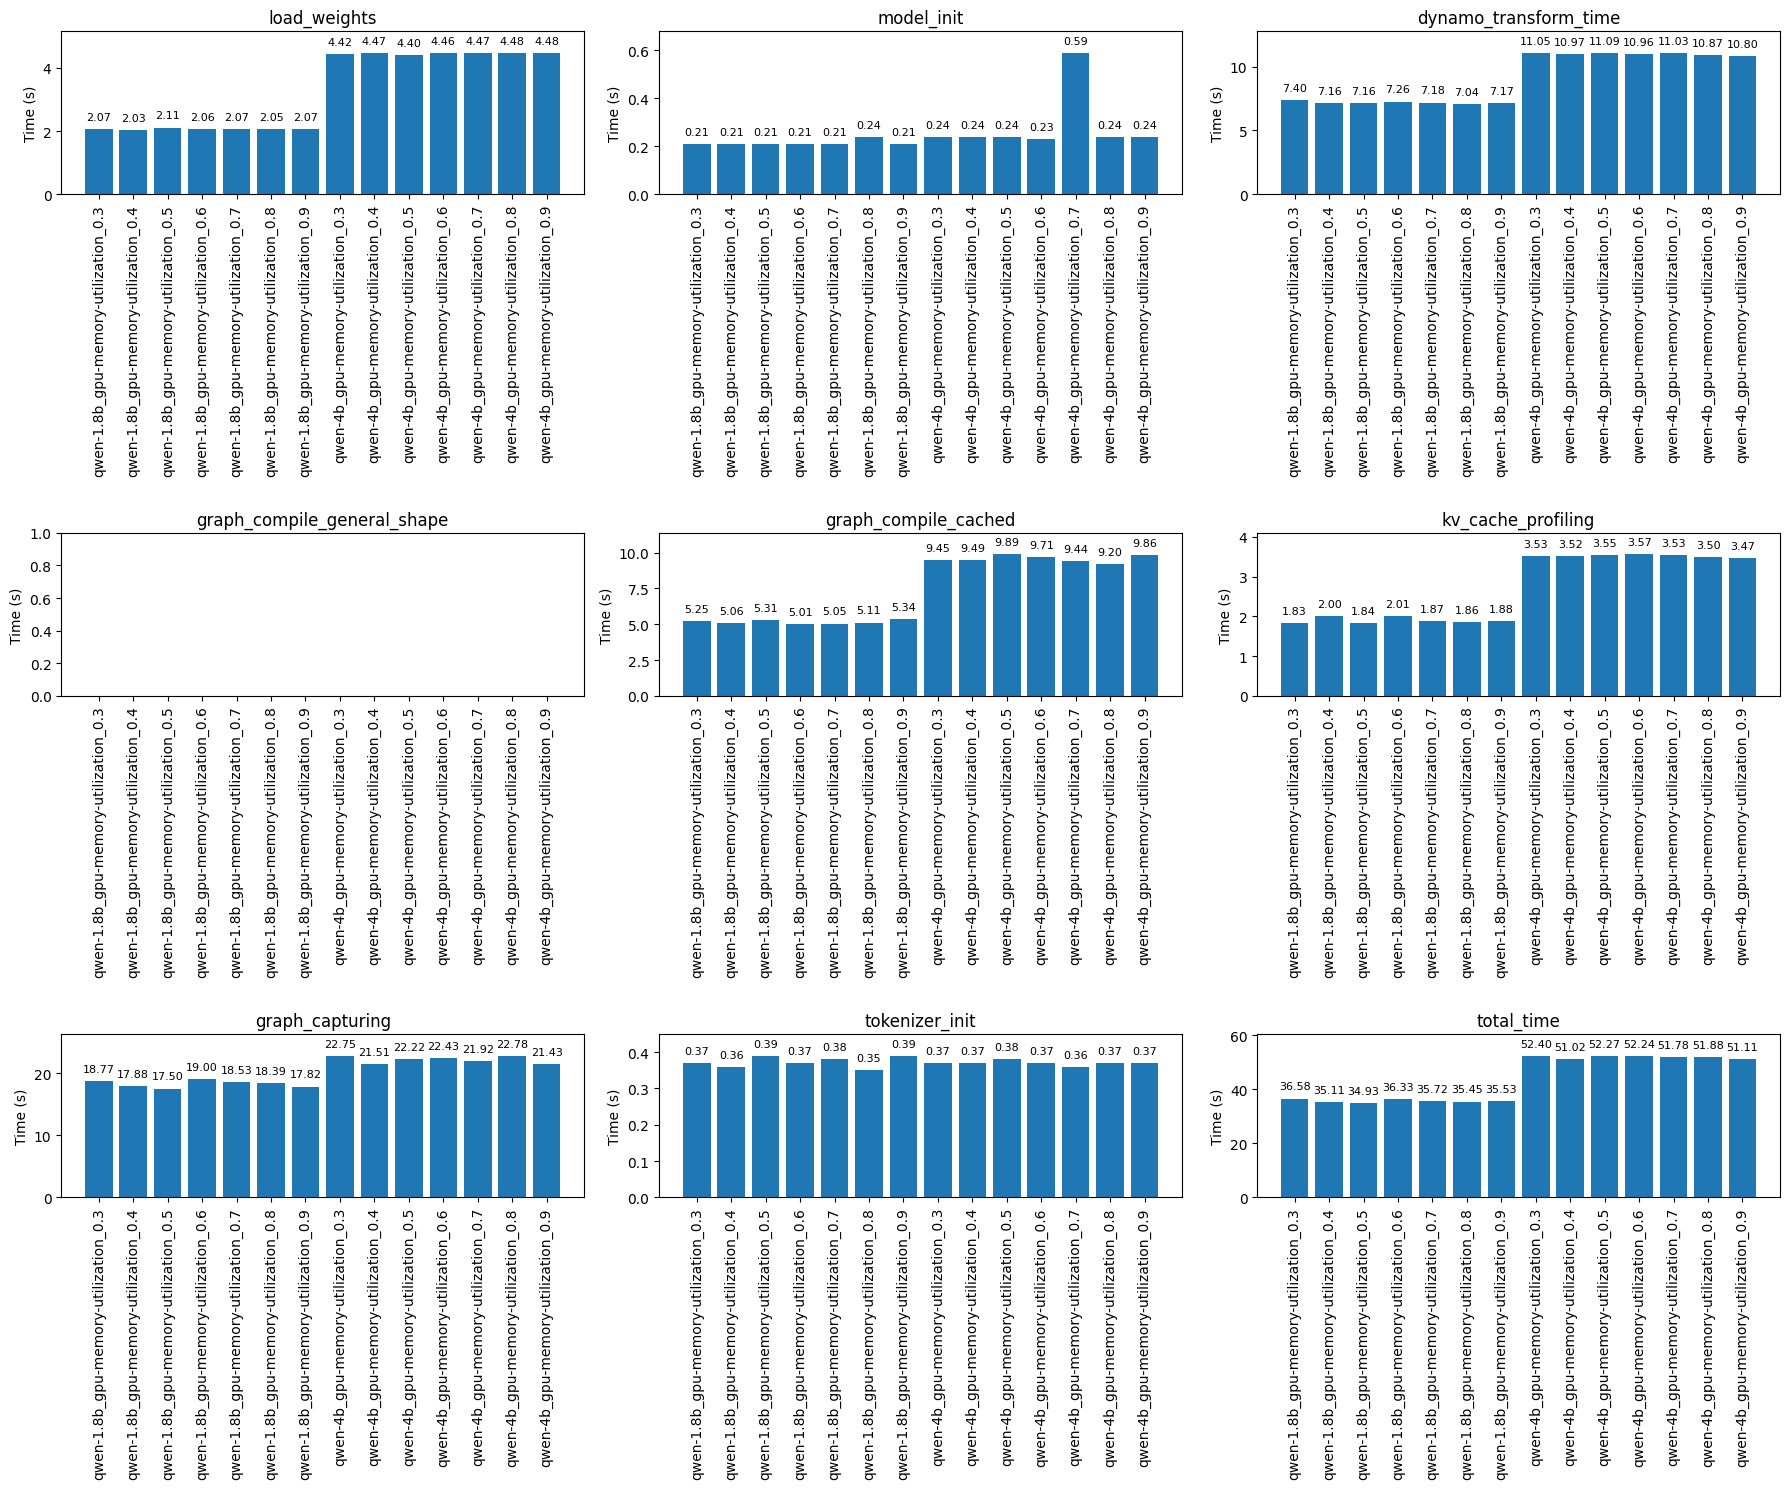

In [ ]:
gpu_util_json_filepath = "examples/gpu_util/comparison_results.json"
draw_graph(gpu_util_json_filepath, "alphabetical")

### Analysis

As expected, it has no influence on the latency

## Max Sequence Length To Capture

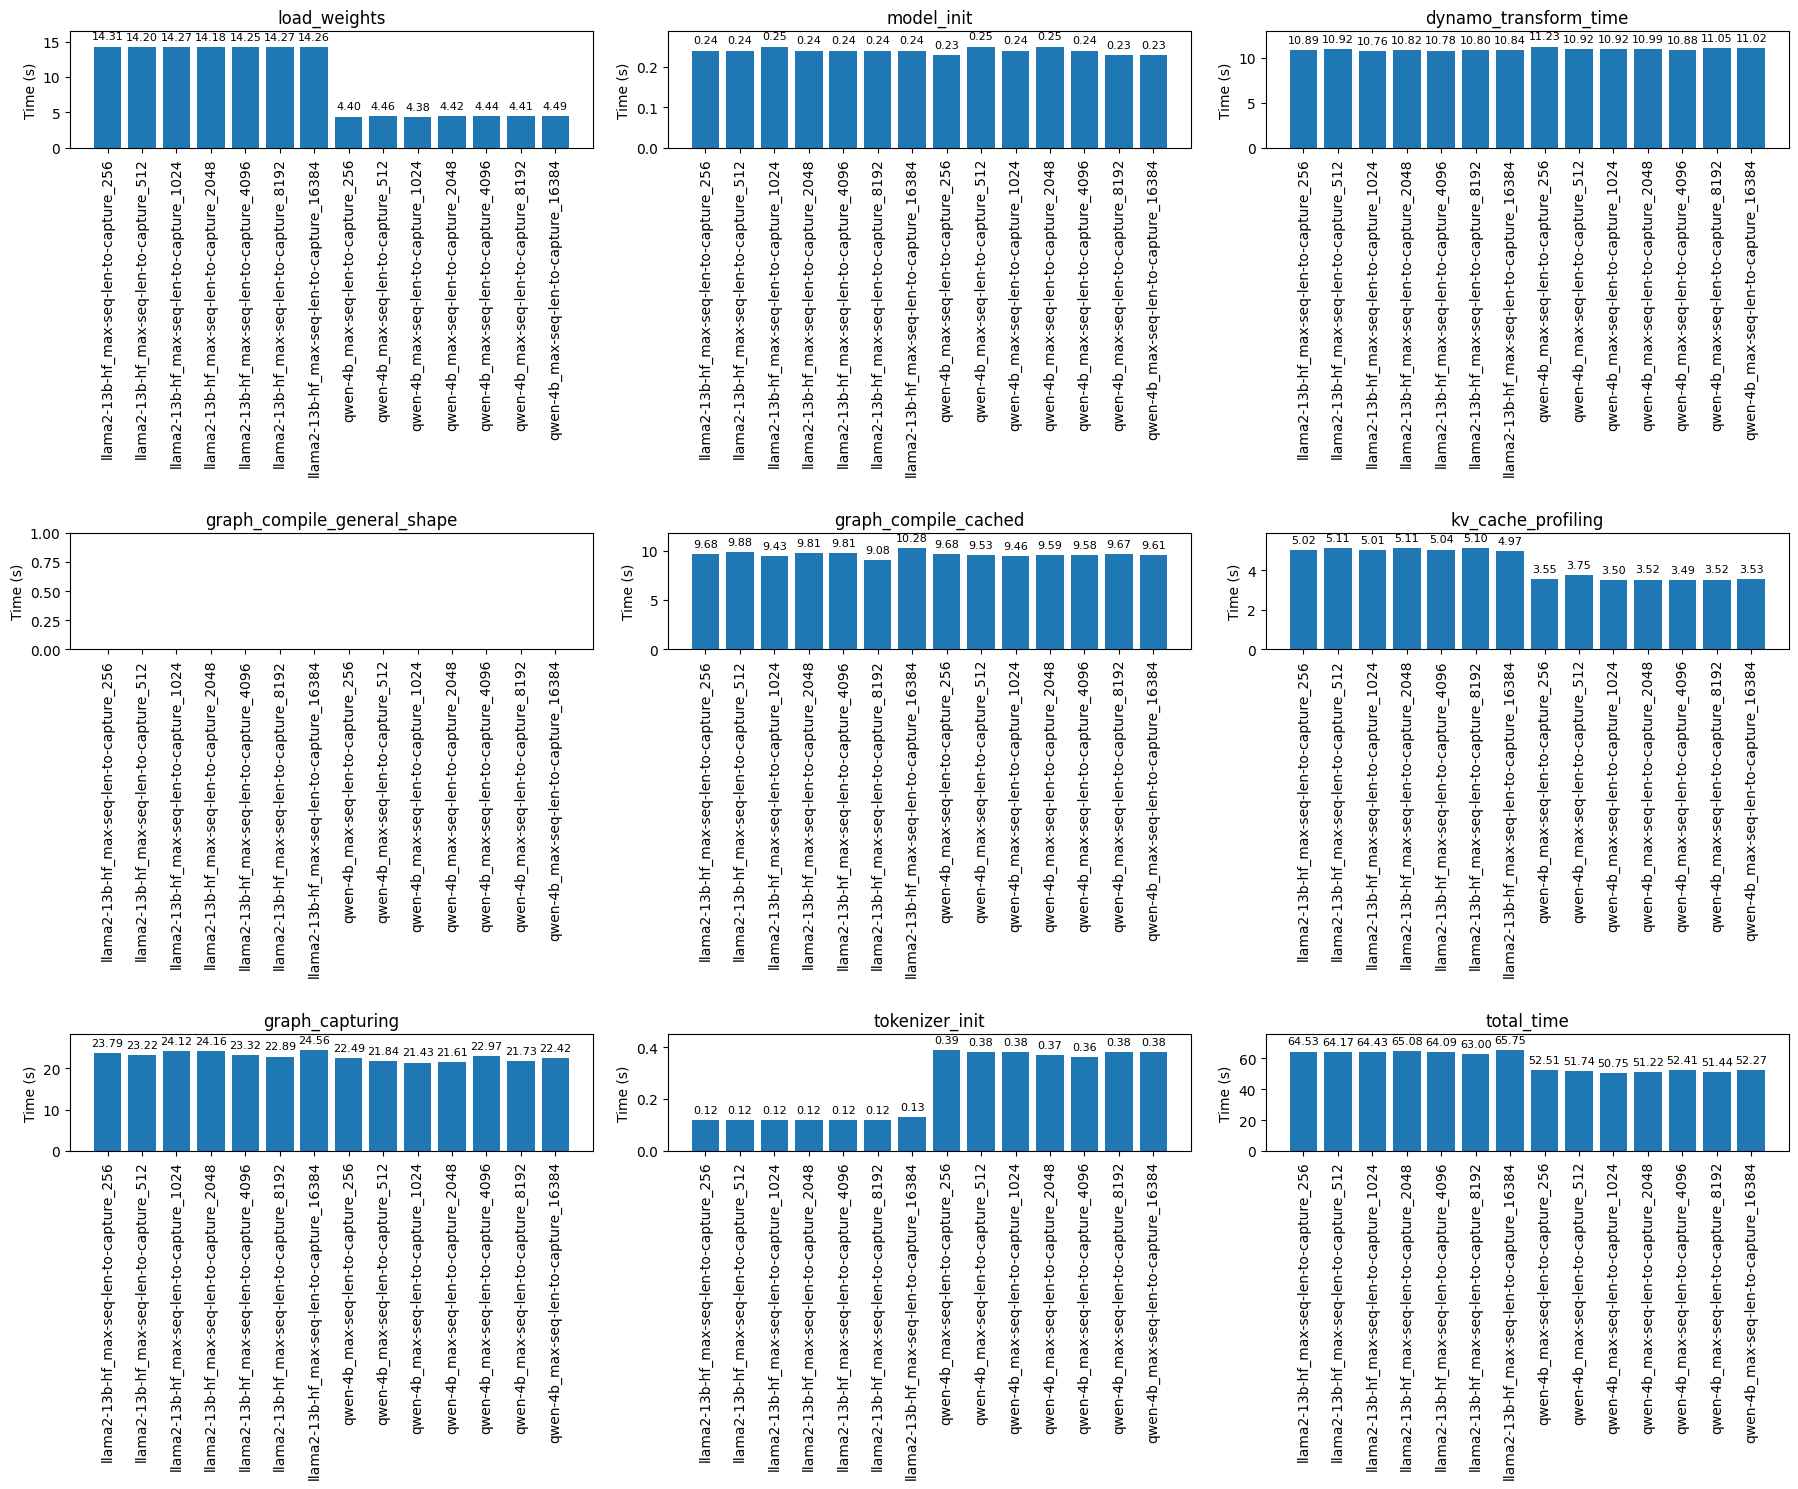

In [ ]:
max_seq_len_json_filepath = "examples/max_seq_len_to_capture/comparison_results.json"
draw_graph(max_seq_len_json_filepath, "alphabetical")

### Analysis

This flag seems to not affect anything at all
Not sure why, my understanding that it should increase capture time or at least memory usage. But nothing changes!

## Max Model Len

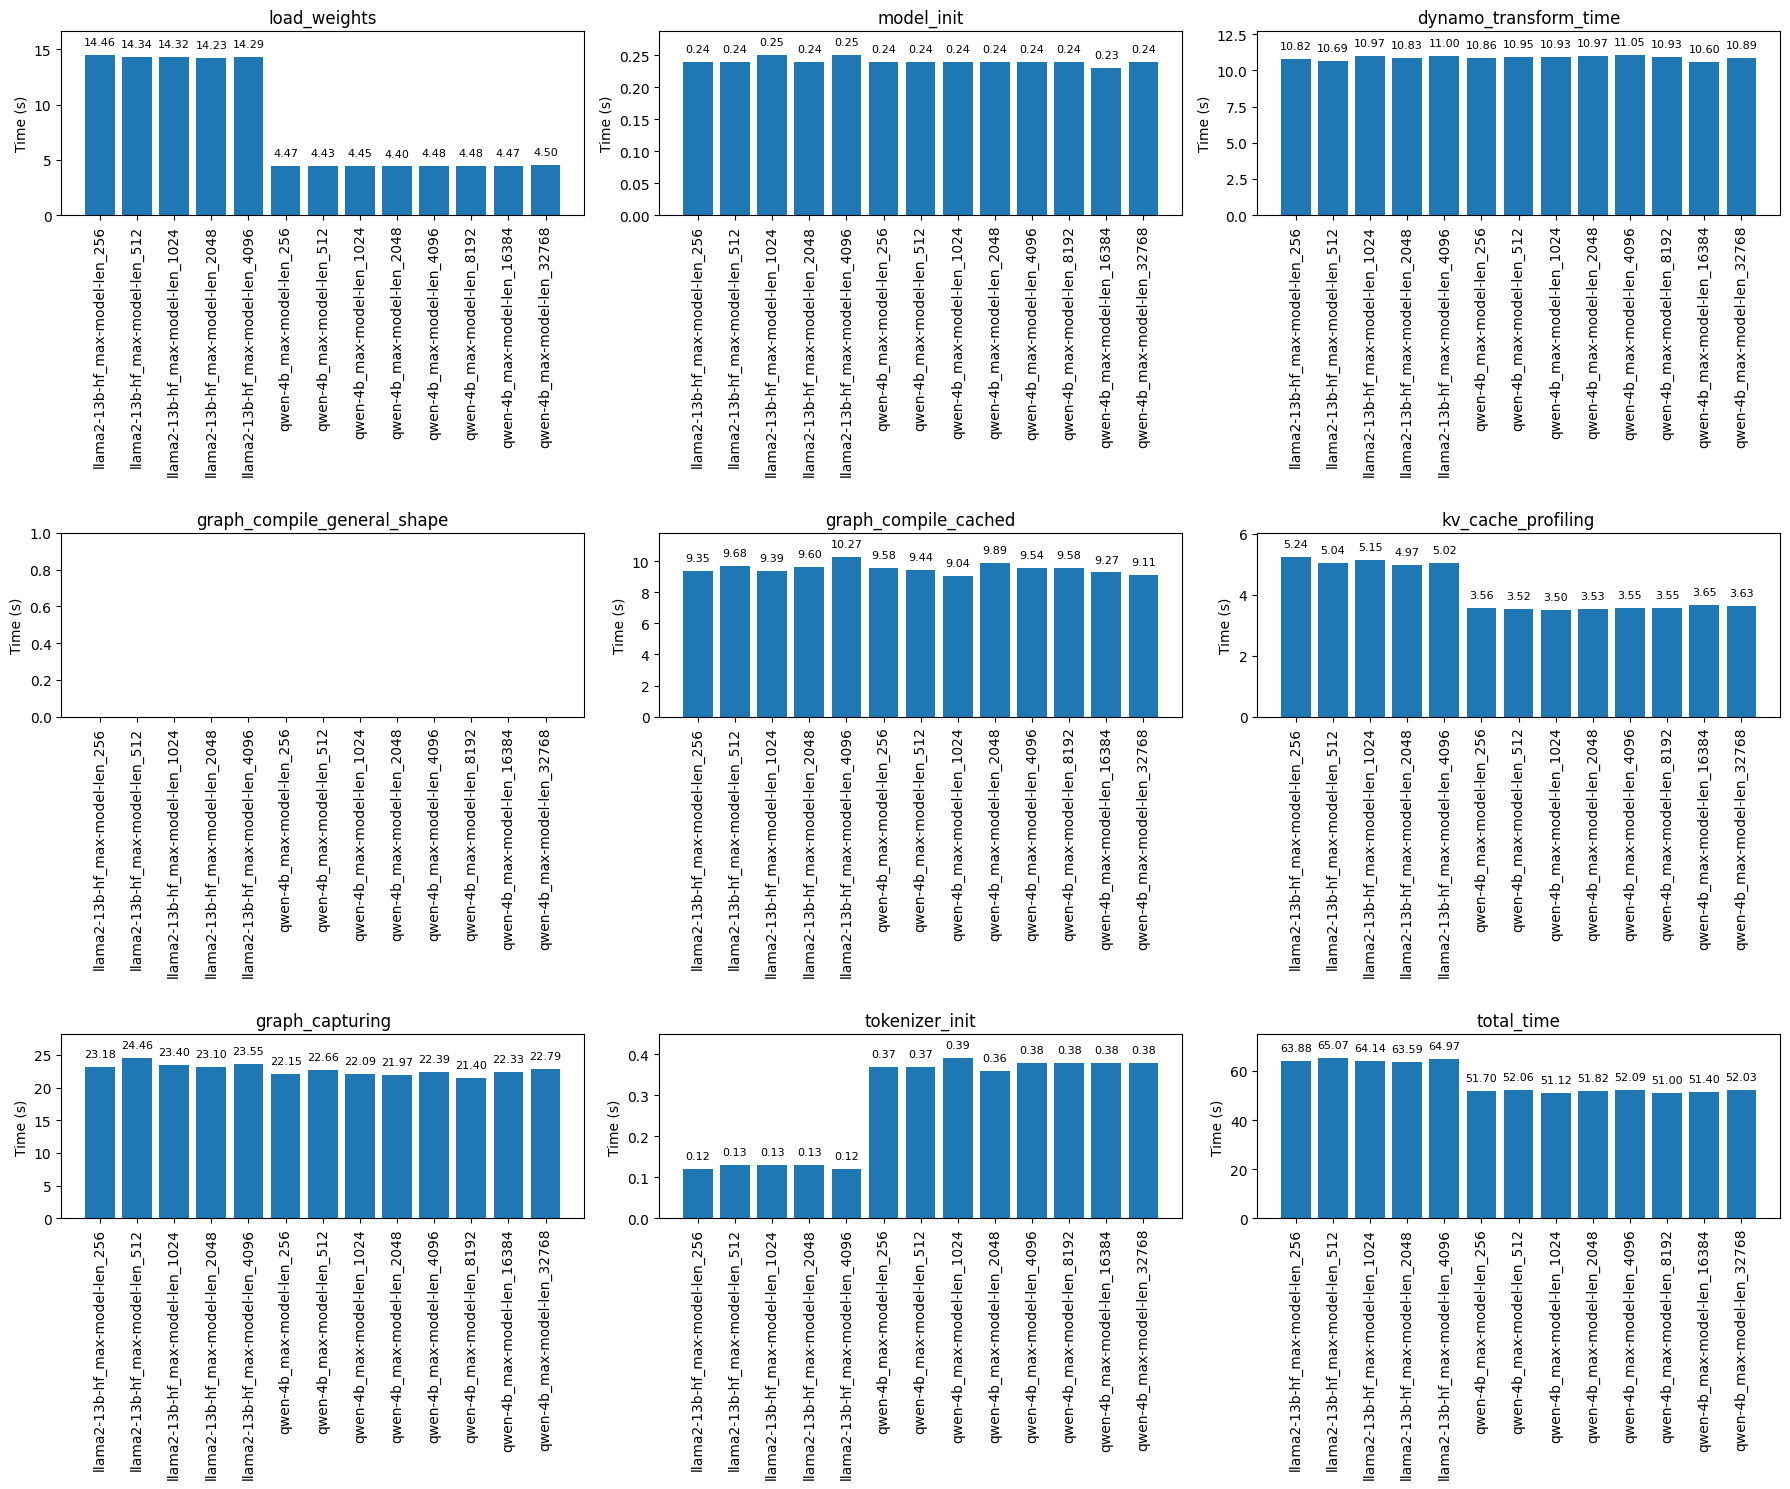

In [ ]:
max_model_len_json_filepath = "examples/max_model_len/comparison_results.json"
draw_graph(max_model_len_json_filepath, "alphabetical")

### Analysis

First of all, changing this requires new compilation (cannot reuse cache)

## Max Num Sequences

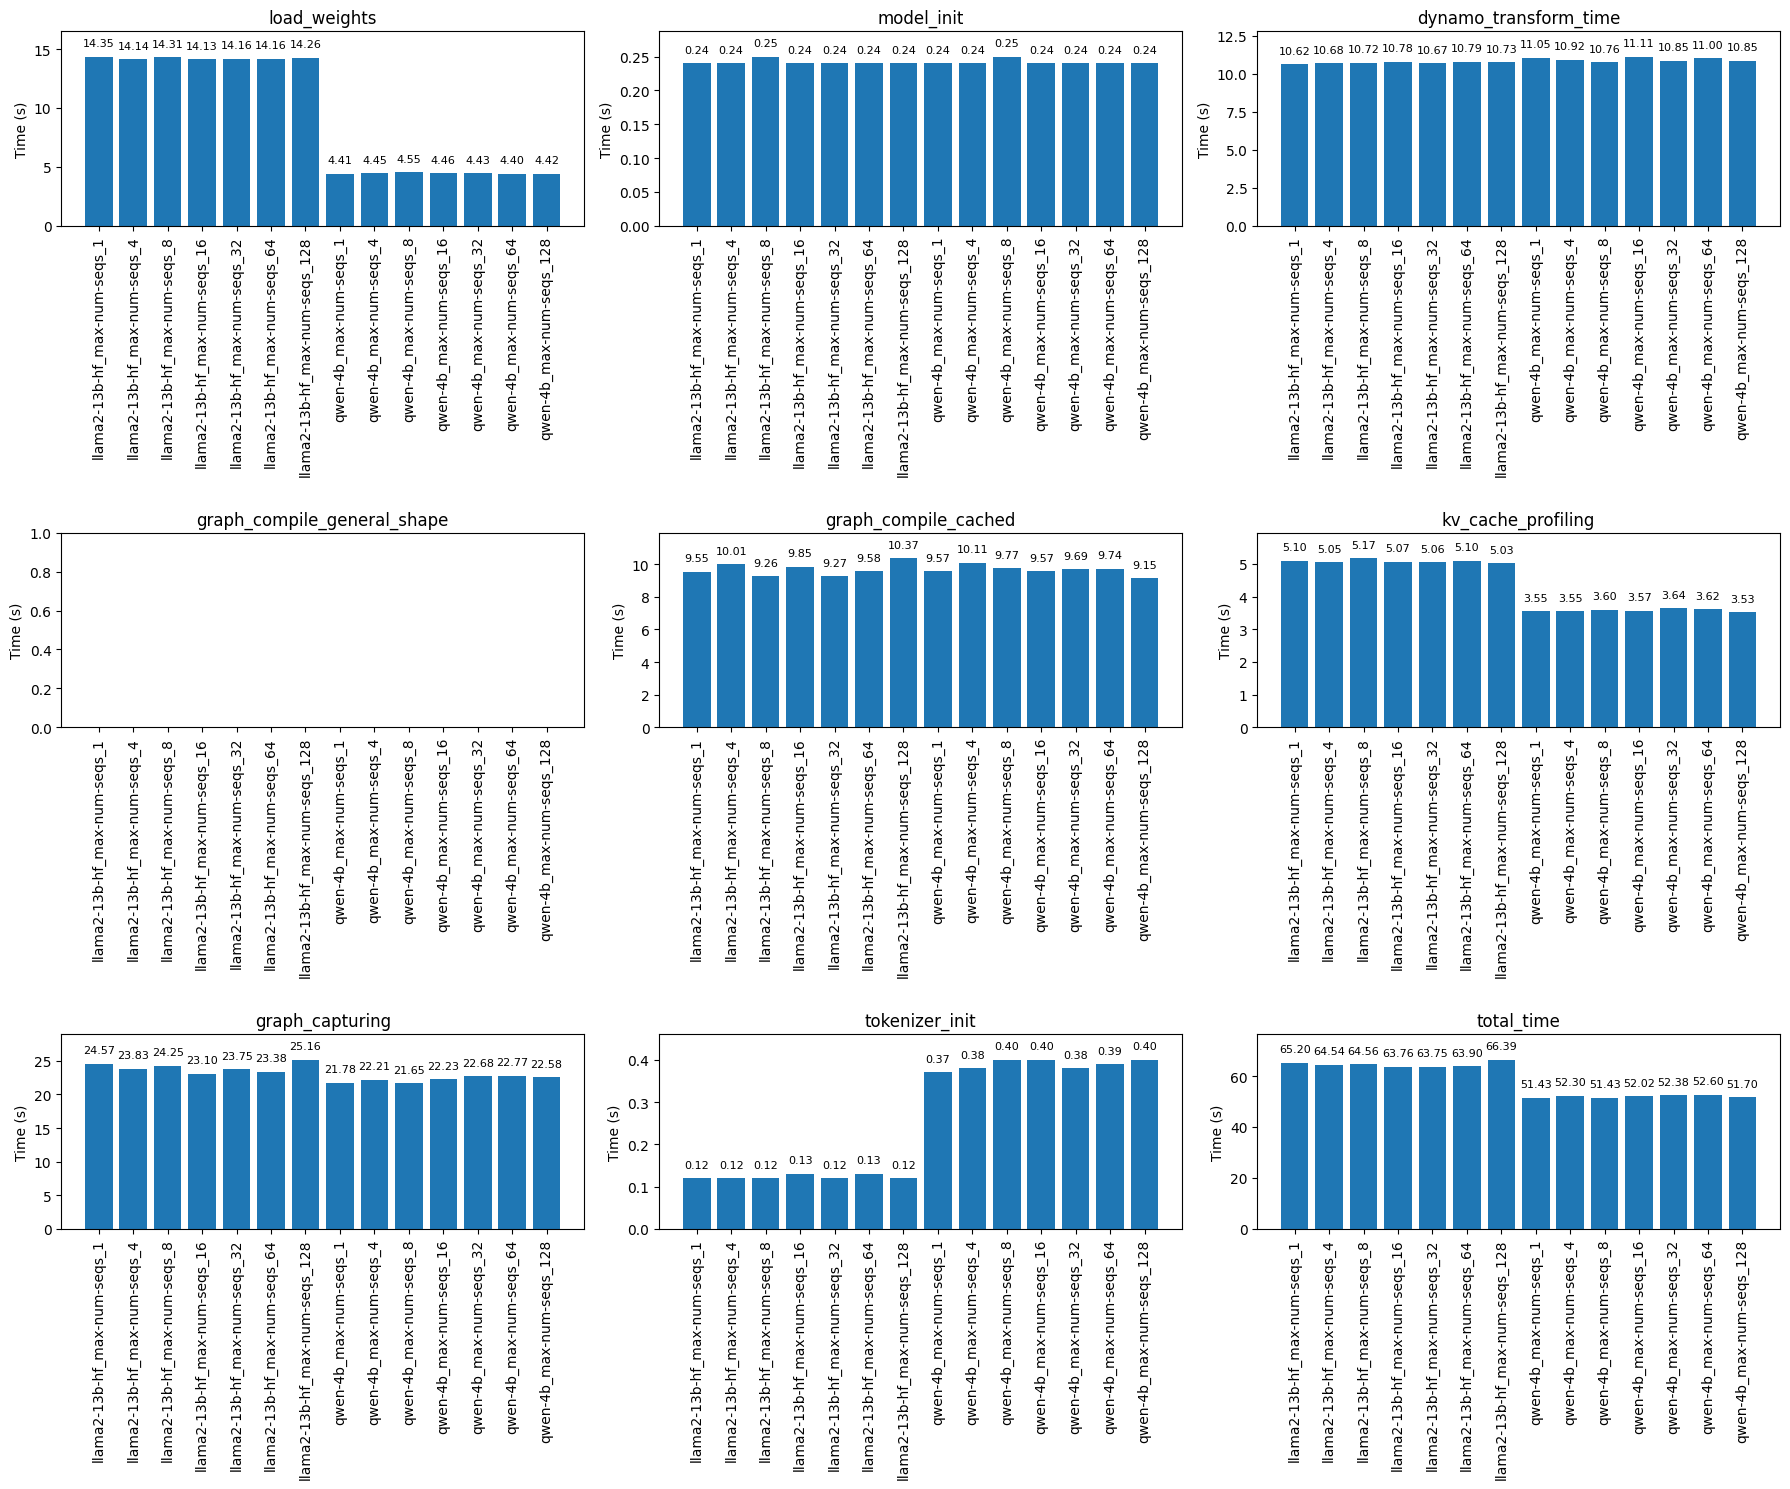

In [ ]:
max_num_seqs_json_filepath = "examples/max_num_seqs/comparison_results.json"
draw_graph(max_num_seqs_json_filepath, "alphabetical")